In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import bisect

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
indexData = pd.read_csv('../data/indexData_uk_uint16.txt', sep='\t', header=None)

In [3]:
header = ['Term', 'Li_Len', '1s_Qnt', '1rl_Avg', 'Liwo1_Len', 'C_Li_Len', 'C_Liwo1_Len', 'Bitmap_Bytes',
          'Bitmap_BytesOnDisk', 'EWAH_bitmap_Bytes', 'EWAH_bitmap_BytesOnDisk', 'Bitmap_1s']
indexData.columns = header

In [4]:
#indexData['Bitmap_Bytes'] = indexData.Li_Len / 8 + 1
indexData['Li_Bytes'] = indexData.Li_Len * 4
indexData['Liwo1_Bytes'] = indexData.Liwo1_Len * 4
indexData['C_Li_Bytes'] = indexData.C_Li_Len * 4
indexData['C_Liwo1_Bytes'] = indexData.C_Liwo1_Len * 4
indexData['Ones_Ratio'] = indexData['1s_Qnt'] / indexData.Li_Len

# SS_Ratio (Space Saving): 1 - (CompressedSize / UncompressedSize) #
indexData['SS_Ratio_Li'] = 1 - (indexData.C_Li_Bytes / indexData.Li_Bytes)
indexData['SS_Ratio_Liwo1'] = 1 - (indexData.C_Liwo1_Bytes / indexData.Liwo1_Bytes)

indexData['SS_Ratio_Hybrid_Un'] = 1 - (indexData.Liwo1_Bytes + indexData.Bitmap_Bytes) / indexData.Li_Bytes
indexData['SS_Ratio_Hybrid_Co'] = 1 - (indexData.C_Liwo1_Bytes + indexData.EWAH_bitmap_Bytes) / indexData.Li_Bytes

indexData['SS_Ratio_Hybrid_Un_woBitmap'] = 1 - (indexData.Liwo1_Bytes) / indexData.Li_Bytes
indexData['SS_Ratio_Hybrid_Co_woBitmap'] = 1 - (indexData.C_Liwo1_Bytes) / indexData.Li_Bytes

In [5]:
indexData[indexData.columns[1:]]
#indexData[['SS_Ratio_Li', 'SS_Ratio_Liwo1', 'SS_Ratio_Hybrid_Un', 'SS_Ratio_Hybrid_Co']]

,Li_Len,1s_Qnt,1rl_Avg,Liwo1_Len,C_Li_Len,C_Liwo1_Len,Bitmap_Bytes,Bitmap_BytesOnDisk,EWAH_bitmap_Bytes,EWAH_bitmap_BytesOnDisk,...,Liwo1_Bytes,C_Li_Bytes,C_Liwo1_Bytes,Ones_Ratio,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co,SS_Ratio_Hybrid_Un_woBitmap,SS_Ratio_Hybrid_Co_woBitmap
0,528517,216943,2.036,311574,53021,35449,27118,27126,110,126,...,1246296,212084,141796,0.410,0.900,0.886,0.398,0.933,0.410,0.933
1,171519,31866,1.698,139653,25845,22452,3984,3992,18,34,...,558612,103380,89808,0.186,0.849,0.839,0.180,0.869,0.186,0.869
2,138044,20468,1.628,117576,22408,20154,2560,2568,14,30,...,470304,89632,80616,0.148,0.838,0.829,0.144,0.854,0.148,0.854
3,818,2,1.000,816,366,365,2,10,4,20,...,3264,1464,1460,0.002,0.553,0.553,0.002,0.553,0.002,0.554
4,184,5,1.000,179,91,90,2,10,4,20,...,716,364,360,0.027,0.505,0.497,0.024,0.505,0.027,0.511
5,865,223,5.868,642,305,282,28,36,4,20,...,2568,1220,1128,0.258,0.647,0.561,0.250,0.673,0.258,0.674
6,416,5,1.250,411,206,204,2,10,4,20,...,1644,824,816,0.012,0.505,0.504,0.011,0.507,0.012,0.510
7,265,1,1.000,264,137,141,2,10,4,20,...,1056,548,564,0.004,0.483,0.466,0.002,0.464,0.004,0.468
8,407,2,1.000,405,188,184,2,10,4,20,...,1620,752,736,0.005,0.538,0.546,0.004,0.545,0.005,0.548
9,4,1,1.000,3,3,3,2,10,4,20,...,12,12,12,0.250,0.250,0.000,0.125,0.000,0.250,0.250


In [6]:
# Size of vocabulary: 14813510 (terms) #
# 2134281 / 14813510 = 0.144076657 #
indexData[indexData.columns[9:]].describe()

,EWAH_bitmap_Bytes,EWAH_bitmap_BytesOnDisk,Bitmap_1s,Li_Bytes,Liwo1_Bytes,C_Li_Bytes,C_Liwo1_Bytes,Ones_Ratio,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co,SS_Ratio_Hybrid_Un_woBitmap,SS_Ratio_Hybrid_Co_woBitmap
count,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000
mean,4.129,20.129,453.957,11237.440,9421.613,2342.826,2168.875,0.072,0.586,0.560,0.060,0.580,0.072,0.602
std,5.067,5.067,10392.917,83814.369,51883.224,10064.419,8120.778,0.116,0.140,0.210,0.104,0.175,0.116,0.138
min,2.000,18.000,1.000,8.000,4.000,8.000,8.000,0.001,0.000,-1.000,0.000,-0.500,0.001,0.000
25%,4.000,20.000,1.000,260.000,240.000,108.000,96.000,0.012,0.501,0.496,0.008,0.500,0.012,0.513
50%,4.000,20.000,4.000,912.000,852.000,360.000,352.000,0.030,0.589,0.579,0.024,0.590,0.030,0.603
75%,4.000,20.000,23.000,3052.000,2916.000,1132.000,1108.000,0.082,0.687,0.678,0.067,0.695,0.082,0.702
max,542.000,558.000,1101122.000,5007524.000,1354852.000,295416.000,149568.000,0.997,0.943,0.923,0.966,0.992,0.997,0.995


In [7]:
bins = np.array((.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.), dtype=np.float64)
count_won_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)
count_lost_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)

#won_SS_SS_Ratio_Hybrid_Co = indexData[indexData['SS_Ratio_Hybrid_Co'] > indexData['SS_Ratio_Hybrid_Co']]['SS_Ratio_Hybrid_Co']
won_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])
lost_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])

# Interval Type [) #
for SS_Ratio_Hybrid_Co in won_SS_Ratio_Hybrid_Co:
    count_won_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
for SS_Ratio_Hybrid_Co in lost_SS_Ratio_Hybrid_Co:
    # First interval includes NEGATIVE values #
    count_lost_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
    
# Slower! #
#for index, row in indexData.iterrows():
#    if (row.SS_Ratio_Hybrid_Co > row.SS_Ratio_Li):
#        count_won_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1
#    else: # row.SS_Ratio_Hybrid_Co <= row.SS_Ratio_Li] #
#        count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Co = (count_won_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100
count_lost_SS_Ratio_Hybrid_Co = (count_lost_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon\t\tLost'
previousBin = 0.0
totalWon = 0.0
totalLost = 0.0
for won, lost, bi in zip(count_won_SS_Ratio_Hybrid_Co, count_lost_SS_Ratio_Hybrid_Co, bins):
    print '[%.1f, %.1f)\t%.2f\t\t%.2f' %(previousBin, bi, won, lost)
    previousBin = bi
    totalWon += won
    totalLost += lost
print 'Total\t\t%.2f\t\t%.2f' %(totalWon, totalLost)


Bin		Won		Lost
[0.0, 0.1)	0.00		1.92
[0.1, 0.2)	0.00		1.10
[0.2, 0.3)	0.00		1.31
[0.3, 0.4)	0.00		3.52
[0.4, 0.5)	1.59		14.83
[0.5, 0.6)	8.56		19.17
[0.6, 0.7)	12.47		11.54
[0.7, 0.8)	14.48		4.16
[0.8, 0.9)	4.10		0.82
[0.9, 1.0)	0.44		0.00
Total		41.64		58.36


In [8]:
won_Hybrid_Co = indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')
lost_Hybrid_Co = indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')

print 'Posting List Lenght (Li_Bytes)'
print '\tAverage\t\tStd\t\tMin\t\tMax'
print 'Won\t%.2f\t%.2f\t%i\t\t%i' %(won_Hybrid_Co.Li_Bytes.mean(), won_Hybrid_Co.Li_Bytes.std(),
                                    won_Hybrid_Co.Li_Bytes.min(), won_Hybrid_Co.Li_Bytes.max())
print 'Lost\t%.2f\t\t%.2f\t\t%i\t\t%i' %(lost_Hybrid_Co.Li_Bytes.mean(), lost_Hybrid_Co.Li_Bytes.std(),
                                         lost_Hybrid_Co.Li_Bytes.min(), lost_Hybrid_Co.Li_Bytes.max())

print ''
print 'Average 1\'s run Lenght (1rl_Avg)'
print '\tAverage\t\tStd\t\tMin\t\tMax'
print 'Won\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(won_Hybrid_Co['1rl_Avg'].mean(), won_Hybrid_Co['1rl_Avg'].std(),
                                            won_Hybrid_Co['1rl_Avg'].min(), won_Hybrid_Co['1rl_Avg'].max())
print 'Lost\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(lost_Hybrid_Co['1rl_Avg'].mean(), lost_Hybrid_Co['1rl_Avg'].std(),
                                             lost_Hybrid_Co['1rl_Avg'].min(), lost_Hybrid_Co['1rl_Avg'].max())

print ''
print '1\'s Ratio (Ones_Ratio)'
print '\tAverage\t\tStd\t\tMin\t\tMax'
print 'Won\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(won_Hybrid_Co['Ones_Ratio'].mean(), won_Hybrid_Co['Ones_Ratio'].std(),
                                            won_Hybrid_Co['Ones_Ratio'].min(), won_Hybrid_Co['Ones_Ratio'].max())
print 'Lost\t%.2f\t\t%.2f\t\t%.4f\t\t%.4f' %(lost_Hybrid_Co['Ones_Ratio'].mean(), lost_Hybrid_Co['Ones_Ratio'].std(),
                                             lost_Hybrid_Co['Ones_Ratio'].min(), lost_Hybrid_Co['Ones_Ratio'].max())

Posting List Lenght (Li_Bytes)
	Average		Std		Min		Max
Won	25435.52	128524.70	28		5007524
Lost	1107.12		2177.21		8		45236

Average 1's run Lenght (1rl_Avg)
	Average		Std		Min		Max
Won	4.27		16.05		1.0000		399.0000
Lost	1.28		2.03		1.0000		162.0000

1's Ratio (Ones_Ratio)
	Average		Std		Min		Max
Won	0.10		0.14		0.0008		0.9975
Lost	0.05		0.09		0.0006		0.8333


In [9]:
count_won_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)
#count_lost_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)

won_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un > 0')['SS_Ratio_Hybrid_Un'])
#lost_SS_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un <= 0')['SS_Ratio_Hybrid_Un'])

# Interval Type [) #
for SS_Ratio_Hybrid_Un in won_SS_Ratio_Hybrid_Un:
    count_won_SS_Ratio_Hybrid_Un[bisect.bisect_right(bins, SS_Ratio_Hybrid_Un)] += 1
#for SS_Ratio_Hybrid_Co in lost_SS_SS_Ratio_Hybrid_Un:
#    count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Un = (count_won_SS_Ratio_Hybrid_Un / indexData.shape[0]) * 100
#count_lost_SS_SS_Ratio_Hybrid_Co = (count_lost_SS_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon'
previousBin = 0.0
totalWon = 0.0
for won, bi in zip(count_won_SS_Ratio_Hybrid_Un, bins):
    print '[%.1f, %.1f)\t%.2f' %(previousBin, bi, won)
    previousBin = bi
    totalWon += won
print 'Total\t\t%.2f' %(totalWon)



Bin		Won
[0.0, 0.1)	83.23
[0.1, 0.2)	10.44
[0.2, 0.3)	3.21
[0.3, 0.4)	0.97
[0.4, 0.5)	0.79
[0.5, 0.6)	0.43
[0.6, 0.7)	0.43
[0.7, 0.8)	0.21
[0.8, 0.9)	0.13
[0.9, 1.0)	0.17
Total		100.00


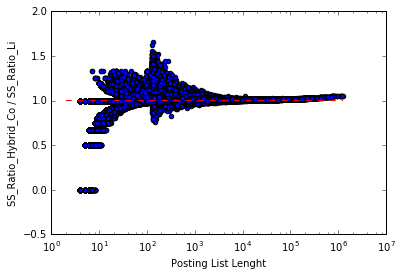

In [10]:
# SS_Ratio_Hybrid_Co / SS_Ratio_Li #

SS_Ratio_Hybrid_Co_over_SS_Ratio_Li = indexData.SS_Ratio_Hybrid_Co / indexData.SS_Ratio_Li

start = indexData.Li_Len.min()
stop = indexData.Li_Len.max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData.Li_Len, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)

ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')
#ax.set_yscale('log')

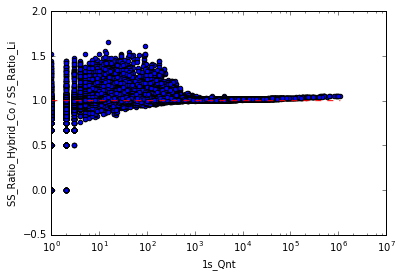

In [11]:
start = indexData['1s_Qnt'].min()
stop = indexData['1s_Qnt'].max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData['1s_Qnt'], SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.set_xlabel('1s_Qnt')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')

(0.0, 1.1)

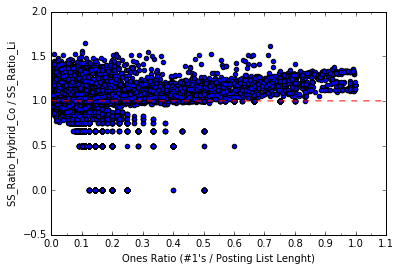

In [12]:
# How many ones do I need to win? #
# X-axis : One's proportion respect to Posting List Length #
# Y-axis : Hybrid Compression Ratio: HybridCompression / PForCompression #

start = 0.0
stop = 1.1

size = indexData.shape[0]

s = np.linspace(start, stop, size, dtype=np.float64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.scatter(indexData.Ones_Ratio, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.plot(s, threshold, color='r', linestyle='--')
# Tickers #
min_x = MultipleLocator(0.05)
max_x = MultipleLocator(0.1)
ax.xaxis.set_major_locator(max_x)
ax.xaxis.set_minor_locator(min_x)
ax.set_xlabel('Ones Ratio (#1\'s / Posting List Lenght)')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xlim([0.0, 1.1])